Perform CIFAR10 classification using ResNet18.

1) Train ResNet18 from Scratch


2) Finetune ResNet from Pretarined network on ImageNet

#take a Resnet model trained using imagenet and fine-tune it on CIFAR10

**The running time should be about 8 minites.**

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torch.optim import lr_scheduler 


In [24]:
# CIFAR10
def cifar10(batch_sz, path='./datasets'):
    num_classes = 10
    transform_train = transforms.Compose([
                        transforms.RandomCrop(32, padding=4),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                    ])
    transform_test = transforms.Compose([
                        transforms.ToTensor(),
                    ])

    # Training dataset
    train_data = CIFAR10(root=path, train=True, download=True, transform=transform_train)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz,
                                               shuffle=True, pin_memory=True)

    # Test dataset
    test_data = CIFAR10(root=path, train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, test_loader, num_classes


In [25]:
batch_sz=64 # this is batch size i.e. the number of rows in a batch of data
train_loader, test_loader, _=cifar10(batch_sz) 

Files already downloaded and verified
Files already downloaded and verified


The ResNet18 below is trained from scratch.

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 9.0000e-02.
Loss: 1.6659 Acc: 0.4030
Adjusting learning rate of group 0 to 8.1000e-02.
Loss: 1.1968 Acc: 0.5690
Adjusting learning rate of group 0 to 7.2900e-02.
Loss: 1.0127 Acc: 0.6399
Adjusting learning rate of group 0 to 6.5610e-02.
Loss: 0.8976 Acc: 0.6828
Adjusting learning rate of group 0 to 5.9049e-02.
Loss: 0.8151 Acc: 0.7153
Adjusting learning rate of group 0 to 5.3144e-02.
Loss: 0.7590 Acc: 0.7320
Adjusting learning rate of group 0 to 4.7830e-02.
Loss: 0.7016 Acc: 0.7526
Adjusting learning rate of group 0 to 4.3047e-02.
Loss: 0.6644 Acc: 0.7677
Adjusting learning rate of group 0 to 3.8742e-02.
Loss: 0.6209 Acc: 0.7812
Adjusting learning rate of group 0 to 3.4868e-02.
Loss: 0.5901 Acc: 0.7906


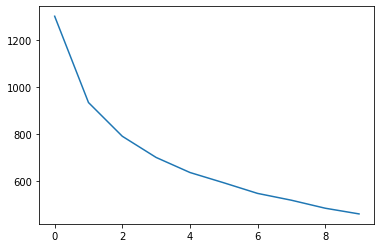

In [26]:
device = torch.device("cuda:0")

net = models.resnet18(num_classes = 10)
net.conv1 = nn.Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3), bias=False)
net = net.to(device)

num_epochs = 10
lr = 0.1
mm = 0.5

ls = []
optimizer = optim.SGD(net.parameters(), lr = lr, momentum = mm)
schduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9, verbose = True)
loss_fn = nn.CrossEntropyLoss()

for i in range(num_epochs):
  total_loss = 0
  '''running_loss = 0.0
  running_corrects = 0'''

  for batch in train_loader:
    X, y = batch[0].to(device),batch[1].to(device)
    logits = net(X)
    loss = loss_fn(logits, y)
    total_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    '''_, preds = torch.max(logits, 1)
    running_loss += loss.item() * X.size(0)
    running_corrects += torch.sum(preds == y.data)'''
  schduler.step()
  ls.append(total_loss)
  '''epoch_loss = running_loss / len(train_loader.dataset)
  epoch_acc = running_corrects.double() / len(train_loader.dataset)

  print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))'''

plt.plot(ls)

The ResNet18 below is pretrained.

In [27]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
#---------------------------------------------------------Come from Jack Collins--------------------------------------------------------------

In [28]:
device = torch.device("cuda:0")
#Reference from:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
model_ft = models.resnet18(pretrained = True)
set_parameter_requires_grad(model_ft, True)
num_ftrs = model_ft.fc.in_features #add an new layer after the fully connect layer
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=mm)

# Decay LR by a factor of 0.1 every 7 epochs
# Changed from 0.1 to 0.5 and it will change every 1 epoch
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=1, gamma=0.5)
#-------------------------------------END---------------------------------------

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loss: 0.5901 Acc: 0.7906
Loss: 0.5901 Acc: 0.7906
Loss: 0.5901 Acc: 0.7906
Loss: 0.5901 Acc: 0.7906
Loss: 0.5901 Acc: 0.7906
Loss: 0.5901 Acc: 0.7906
Loss: 0.5901 Acc: 0.7906
Loss: 0.5901 Acc: 0.7906
Loss: 0.5901 Acc: 0.7906
Loss: 0.5901 Acc: 0.7906


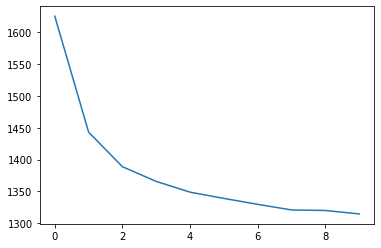

In [29]:

num_epochs = 10
lr = 0.1
mm = 0.5

ls1 = []

for i in range(num_epochs):
  total_loss = 0
  '''running_loss1 = 0.0
  running_corrects1 = 0'''
  for batch in train_loader:
    X, y = batch[0].to(device),batch[1].to(device)
    logits = model_ft(X)
    loss = criterion(logits, y)
    total_loss += loss.item()

    optimizer_ft.zero_grad()
    loss.backward()
    optimizer_ft.step()

    '''_, preds = torch.max(logits, 1)
    running_loss1 += loss.item() * X.size(0)
    running_corrects1 += torch.sum(preds == y.data)'''
  ls1.append(total_loss)
  '''epoch_loss1 = running_loss1 / len(train_loader.dataset)
  epoch_acc1 = running_corrects1.double() / len(train_loader.dataset)
  print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))'''

plt.plot(ls1)

[1302.9739941358566, 935.5280427932739, 791.9366524815559, 701.7188182473183, 637.6487822830677, 593.8842412233353, 548.623844653368, 519.6115421652794, 485.53115195035934, 461.28062242269516]
[1624.7571504116058, 1443.005013346672, 1388.787852525711, 1365.71080160141, 1348.8804100751877, 1339.079028248787, 1329.7581551074982, 1320.972112774849, 1320.117255806923, 1314.742687344551]


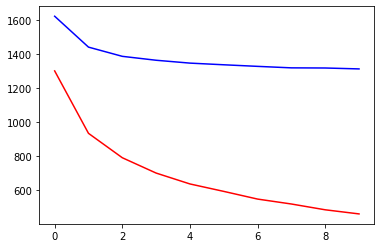

In [30]:
plt.plot(ls,'r')
print(ls)
plt.plot(ls1,'b')
print(ls1)

In [31]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
import torchmetrics as tm
acc = []
accuracy = tm.Accuracy()
for batch in test_loader:
  X, y = batch[0].to(device), batch[1].to(device)
  logits = net(X)
  yhat = torch.argmax(logits, axis = 1)
  a = accuracy(yhat.to("cpu"), y.to("cpu"))
  acc.append(a)

print(np.mean(acc))


acc1 = []
accuracy1 = tm.Accuracy()
for batch in test_loader:
  X, y = batch[0].to(device), batch[1].to(device)
  logits = model_ft(X)
  yhat = torch.argmax(logits, axis = 1)
  a = accuracy1(yhat.to("cpu"), y.to("cpu"))
  acc1.append(a)
acc1_epoch = []

print(np.mean(acc1))

0.778961
0.41839173
